# μA78L05 Analysis and Simulation

By Shuo Chen (chenshuo_at_chenshuo.com)

Latest notebook: https://github.com/chenshuo/notes/blob/master/notebooks/UA78L05.ipynb

In [2]:
%matplotlib inline

import numpy as np
from matplotlib import pyplot as plt

In [3]:
# NgSpice
import ngspyce as ng

In [4]:
# Circuitikz
# pip install git+https://github.com/mkrphys/ipython-tikzmagic.git

%load_ext tikzmagic

In [5]:
def para(r1, r2):
    return (r1*r2) / (r1 + r2)

def print_op(print_base_current=True, print_emitter_current=False):
  op = ng.operating_point()
  for k in sorted(op.keys()):
    if k[0] == '@' or '#branch' in k:
        if '[is]' in k:
            continue
        if '[ib]' in k and not print_base_current:
            continue
        if '[ie]' in k and not print_emitter_current:
            continue

        print('%10s = %8.2f uA' % (k, 1e6*op[k][0]))
    else:
        print('%10s = %8.2f mV' % (k, 1e3*op[k][0]))

## Schematic

The internal schematic is from [_1977 Signetics Analog Data Manual_](http://www.bitsavers.org/components/signetics/_dataBooks/1977_Signetics_Analog_Data_Manual.pdf) p.160.

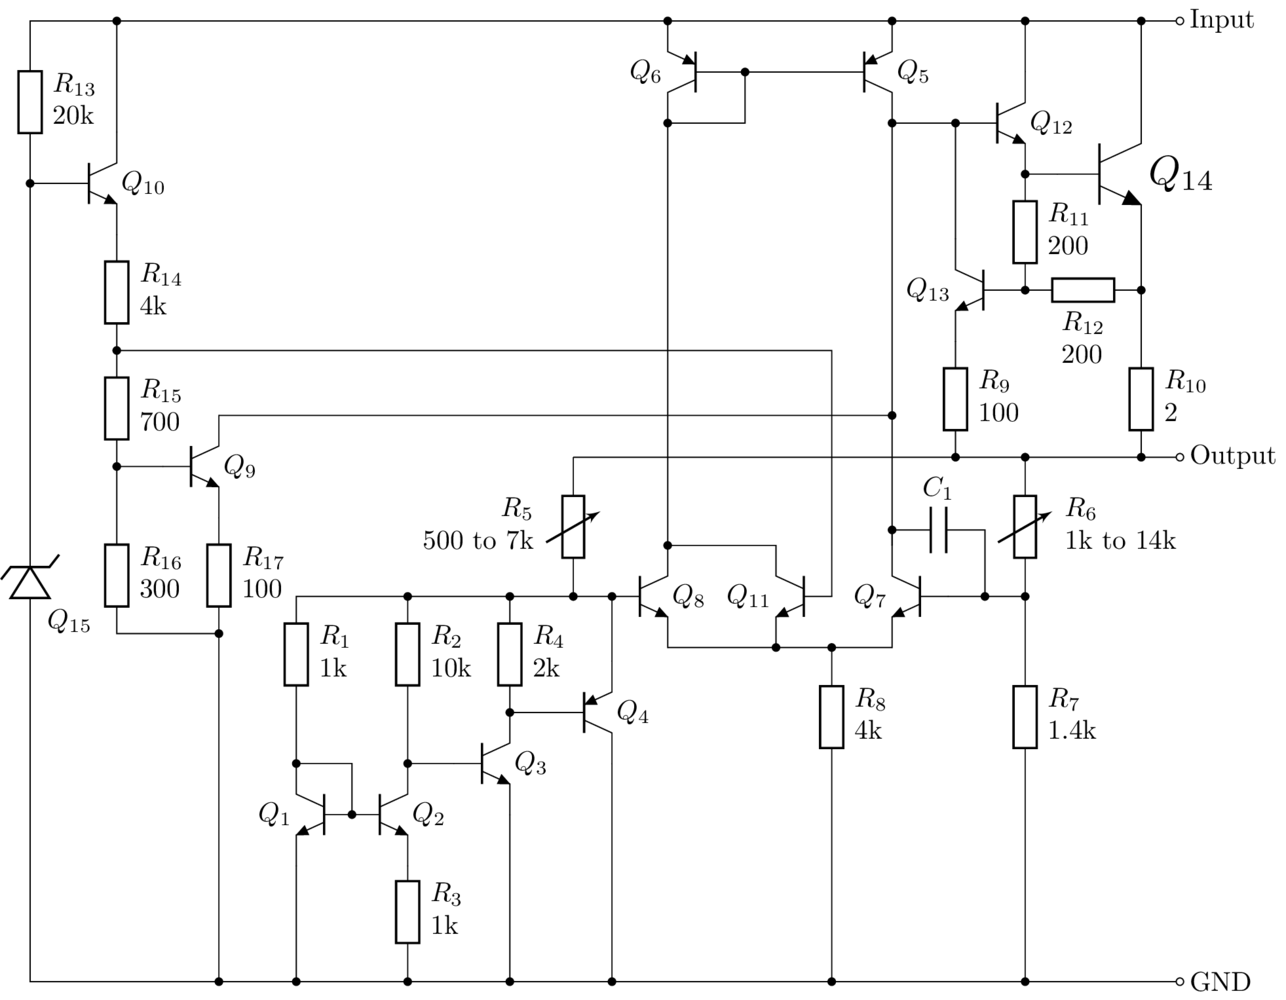

### Simplified

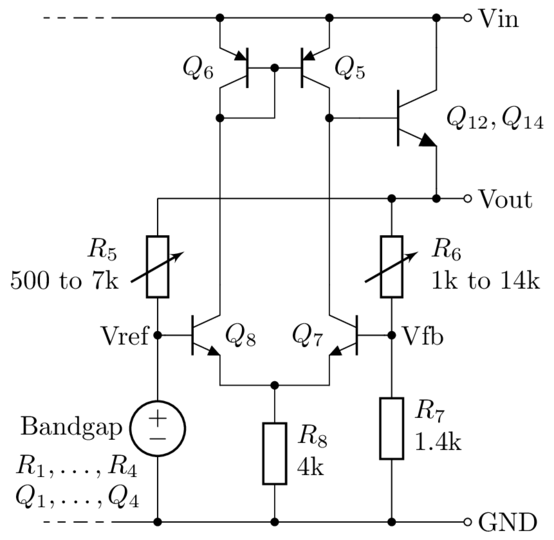

**Estimate the reference voltage**

* $R_6$ sets the output voltage, Vfb = Vref when balanced.
* μA78Lxx series has maximum output voltage of 15V, so I guess $R_6=14$kΩ when Vout=15V.
* Vfb = $\dfrac{1.4}{1.4+14}\times 15 = 15 / 11 = 1.364$V
* Then Vref = 1.364V


### Overly simplified

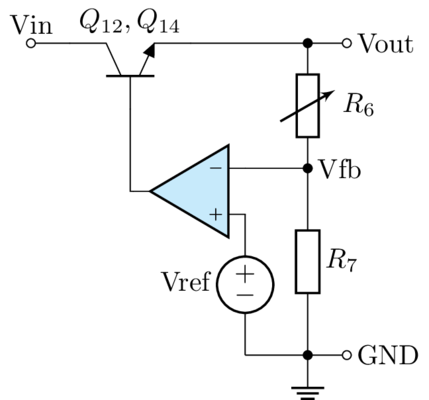

## Bandgap voltage reference

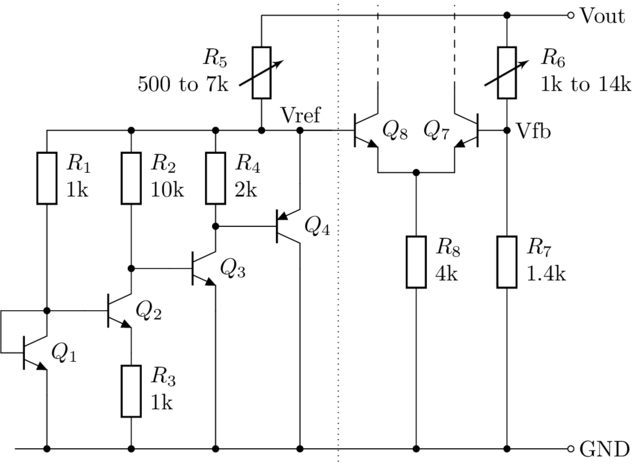

In [8]:
%%tikz -p circuitikz -s 640,600
\ctikzset{european resistors, transistors/arrow pos=end, bipoles/length=1.2cm}
\usetikzlibrary {math}
\tikzmath{\x = 0.6;}

\draw (0, 0) node [npn, anchor=B] (Q2) {$Q_2$};
\draw (Q2.E)
  to [R, l2={$R_3$ and 1k}, bipoles/length=1cm] ++(0, -1.2)
  to [short, -*] ++(0, -0.3) coordinate (G);
% \draw (Q2.B) node [npn, anchor=B, xscale=-1] (Q1) {\ctikzflipx{$Q_1$}};
\draw (Q2.B) to [short, -*] ++(-\x,0) node [npn, anchor=C]  (Q1) {$Q_1$};
\draw (Q1.B) |- (Q1.C);
\draw (Q1.E) to [short, -*] (Q1.E |- G);
\draw (Q2.C) to [short, *-] ++ (\x, 0)
  node [npn, anchor=B] (Q3) {$Q_3$};
\draw (Q3.E) to [short, -*] (Q3.E |- G);
\draw (Q3.C) to [short, *-] ++ (\x, 0)
  node [pnp, anchor=B] (Q4) {$Q_4$};
\draw (Q4.C) to [short, -*] (Q4.C |- G);
\draw (Q3.C)
  to [R, l2_={$R_4$ and 2k}, bipoles/length=1cm] ++(0, 1.5) coordinate (Q8b);
\draw (Q4.E) to [short, -*] (Q4.E |- Q8b)
  to [short] ++(0.5, 0)
  node [npn, anchor=B] (Q8) {$Q_8$};
\draw (Q8b) to [short, *-] (Q8b -| Q1.C)
  to [R, l2={$R_1$ and 1k}, bipoles/length=1cm] ++(0, -1.5) -- (Q1.C);
\draw (Q2.C |- Q8b) node [circ] {}
  to [R, l2={$R_2$ and 10k}, bipoles/length=1cm] ++(0, -1.5) -- (Q2.C);
\draw (Q8.B)++(-0.5, 0)
  node [above] {Vref}
  ++(-0.6, 0) node [circ] {}
  to [vR, mirror, l2={$R_5$ and {500 to 7k}}, l2 halign=r, bipoles/length=1cm] ++(0, 1.8)
  % to [short, -o] ++(1, 0) 
coordinate (OUT) ;
%node [right] {Vout};
\draw (Q8.B) -- (Q8b);

\draw (Q8) ++(1.2, 0)
  node [npn, xscale=-1] (Q7) {\ctikzflipx{$Q_7$}};
\draw (Q8.E) -- (Q7.E);
\draw (Q8.E) ++(0.6, 0) node [circ] {}
  to [R, n=R8, l2={$R_8$ and 4k}, bipoles/length=1cm] ++(0, -2.8)
  to [short, -*] (R8|-G);

% C1
%\draw (Q7.C) to [short, -*] ++(0, 0.2)
%  to [C, l={$C_1$}, bipoles/length=1cm] ++(1.2, 0) coordinate (C1)
%  to [short, -*] (C1 |- Q7.B);

\draw (Q7.B) to [short, -*] ++(0.1, 0) coordinate (R6)
  node [right] {Vfb}
  to [vR, mirror, l2_={$R_6$ and {1k to 14k}}, bipoles/length=1cm] (R6 |- OUT) -- (OUT);
\draw (R6) to [short] (R6|-Q7.E)
  to [R, l2={$R_7$ and 1.4k}, bipoles/length=1cm] ++(0, -2.8)
  to [short, -*] (R6|-G);
\draw (R6 |- OUT) to [short, *-o] ++(1, 0) coordinate (VOUT) node [right] {Vout};

\draw (Q1.E |- G) ++(-0.5, 0) to [short, -o] (G-|VOUT) node [right] {GND};
\draw [dashed] (Q8.C) to [short] ++(0, 1.3);
\draw [dashed] (Q7.C) to [short] ++(0, 1.3);
\draw (Q8.B) ++(0.1, 0) coordinate (DOT);
\draw [dotted] (DOT|-G)++(0, -0.2) to [short] ++(0, 7.2);

Print the DC operating point of following SPICE netlist

```SPICE
  * Bandgap reference of UA78Lxx
  V1 out 0 5V
  R5 out q8b 4k
  R1 q8b q1b 1k
  R2 q8b q3b 10k
  Q1 q1b q1b 0 NPN
  Q2 q3b q1b r3 NPN
  R3 r3 0 1k
  R4 q8b q4b 2k
  Q3 q4b q3b 0 NPN
  Q4 0 q4b q8b PNP
  
  .model NPN NPN(BF=120 Cje=1p Cjc=2p Rb=40 VAF=80 VAR=50 KF=3.2e-16 AF=1)
  .model PNP PNP(BF=60 Cje=1p Cjc=3p Rb=80 VAF=70 VAR=40)
  .options savecurrents
```


In [12]:
ng.circ('''
  V1 out 0 5V
  R5 out q8b 4k
  R1 q8b q1b 1k
  R2 q8b q3b 10k
  Q1 q1b q1b 0 NPN
  Q2 q3b q1b r3 NPN
  R3 r3 0 1k
  R4 q8b q4b 2k
  Q3 q4b q3b 0 NPN
  Q4 0 q4b q8b PNP
  .model NPN NPN(BF=120 Cje=1p Cjc=2p Rb=40 VAF=80 VAR=50 KF=3.2e-16 AF=1)
  .model PNP PNP(BF=60 Cje=1p Cjc=3p Rb=80 VAF=70 VAR=40)
  .options savecurrents
''')

print_op(False, True)

   @q1[ic] =   585.75 uA
   @q1[ie] =  -590.71 uA
   @q2[ic] =    59.05 uA
   @q2[ie] =   -59.55 uA
   @q3[ic] =   259.45 uA
   @q3[ie] =  -261.64 uA
   @q4[ic] =    -0.05 uA
   @q4[ie] =     0.05 uA
    @r1[i] =   591.21 uA
    @r2[i] =    61.24 uA
    @r3[i] =    59.55 uA
    @r4[i] =   259.45 uA
    @r5[i] =   911.95 uA
       out =  5000.00 mV
       q1b =   760.99 mV
       q3b =   739.78 mV
       q4b =   833.31 mV
       q8b =  1352.20 mV
        r3 =    59.55 mV
 v1#branch =  -911.95 uA


The results is

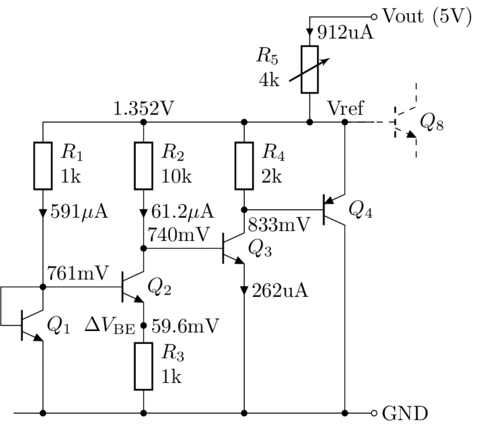

$R_5$ sets the current of bandgap circuit, and affects the temperature curve.

Try finding the best $R_5$.

R5 = 3500, Iq = 1036.6 uA, Vref@27C = 1.372 V, delta =   10.14 mV
R5 = 3600, Iq = 1008.6 uA, Vref@27C = 1.369 V, delta =    6.70 mV
R5 = 3700, Iq =  982.3 uA, Vref@27C = 1.366 V, delta =    3.43 mV
R5 = 3800, Iq =  957.6 uA, Vref@27C = 1.361 V, delta =    0.98 mV
R5 = 3900, Iq =  934.2 uA, Vref@27C = 1.357 V, delta =   -0.78 mV
R5 = 4000, Iq =  912.0 uA, Vref@27C = 1.352 V, delta =   -2.33 mV
R5 = 4100, Iq =  890.8 uA, Vref@27C = 1.348 V, delta =   -3.87 mV
R5 = 4200, Iq =  870.6 uA, Vref@27C = 1.343 V, delta =   -5.47 mV
R5 = 4300, Iq =  851.4 uA, Vref@27C = 1.339 V, delta =   -7.13 mV
R5 = 4400, Iq =  833.0 uA, Vref@27C = 1.335 V, delta =   -8.86 mV


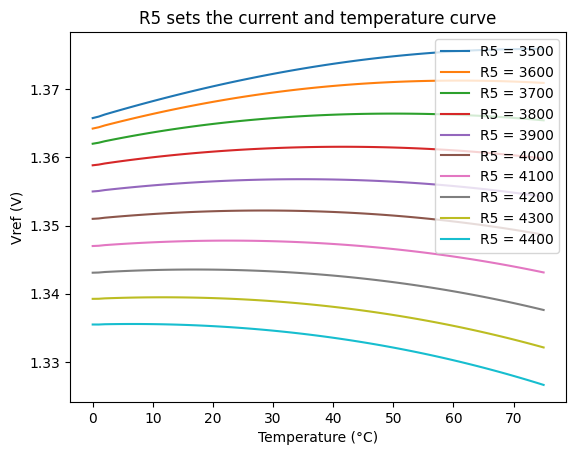

In [21]:
for r5 in range(3500, 4500, 100):
    ng.cmd('alter r5 %d' % r5)
    ng.cmd('dc temp 0 75 1')
    temp = ng.vector('temp-sweep')
    Vout = ng.vector('q8b')
    Ir5 = ng.vector('@r5[i]')
    plt.plot(temp, Vout, label=f'R5 = {r5}')
    delta = Vout[-1] - Vout[0]
    print('R5 = %d, Iq = %6.1f uA, Vref@27C = %.3f V, delta = %7.2f mV' % (r5, 1e6*Ir5[27], Vout[27], delta*1e3))
plt.xlabel('Temperature (°C)')
plt.ylabel('Vref (V)')
plt.title('R5 sets the current and temperature curve')
plt.legend(loc='upper right')

Looks like $R_5=3850$ might be the best candidate for now.

R5 = 3850, Vref@27C = 1.359 V, max-min = 2.190 mV


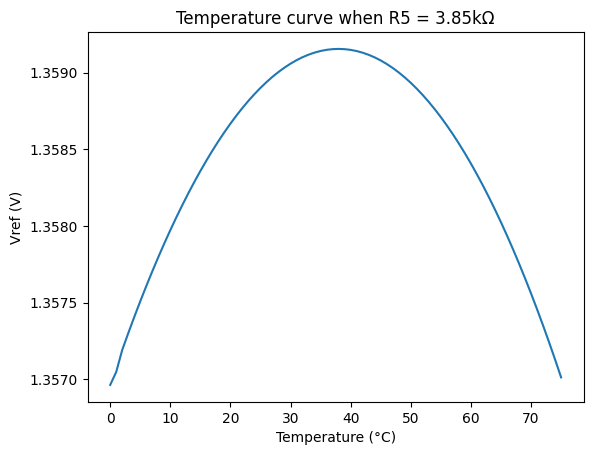

In [24]:
r5 = 3850
ng.cmd('alter r5 %d' % r5)
ng.cmd('dc temp 0 75 1')
temp = ng.vector('temp-sweep')
Vout = ng.vector('q8b')
plt.plot(temp, Vout)
plt.xlabel('Temperature (°C)')
plt.ylabel('Vref (V)')
plt.title('Temperature curve when R5 = 3.85kΩ')
delta = max(Vout) - min(Vout)
print('R5 = %d, Vref@27C = %.3f V, max-min = %.3f mV' % (r5, Vout[27], delta*1e3))

To be continued...